In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%config InlineBackend.figure_format='retina'



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
year = "2019"
data_dir = u"../../Data/"
bin_sample_path = f"{data_dir}binSamples/"
fill_sample_path = f"{data_dir}fillSamples/"
result_path = f"{data_dir}inner_results/"

Use `zipfile` to extract

In [63]:
# path_to_zip_file = f"{data_dir}binSamples.zip"
# directory_to_extract_to = data_dir
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

# path_to_zip_file = f"{data_dir}fillSamples.zip"
# directory_to_extract_to = data_dir
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [3]:
year = "2019"
month_int = 2
bin_sample_path = f"{data_dir}binSamples/"
month = '%02d' % month_int
filename = "bin%s%s.csv" % (year, month)
bin_sample_df = pd.read_csv(bin_sample_path+filename)

Column descriptors:

date - YYYY-MM-DD for the given bin.

time - Time at start of bin.

stock - Stock ticker symbol for the row's binned data.

trade - Signed net number of shares traded over the bin window.

orderFlow - Signed net number of shares added to the book via limit orders (LOs) during the bin window.

hidden - Total number of shares added through hidden LOs during the bin window. Hidden = unknown direction.

auction - Signed volume traded in auctions.

mid - Midprice at the start of the bin window. Defined as arithmetic mean of best bid and best ask prices.

midfin - Midprice at the end of the bin window. Defined as arithmetic mean of best bid and best ask prices.

spread - Spread at start of bin window defined as (ask - bid) / 2.

effSpread - Effective spread at start of bin window defined as average spread paid per trade.

lobImb - Order book imbalance at start of bin window, unnormalized, defined as the ratio of askVolume to bidVolume.

efflobImb - Order book imbalance at start of bin window, defined as average lobImb before each trade.

totVol - Total unsigned number of shares traded in either direction during bin window.

trdVolq - Total unsigned number of shares added to book (at any level) in LOs in either direction during bin window.

ofiLiq - Total unsigned number of shares traded (at any level) in LOs in either direction during bin window.

depth - Sum of volumes at best bid and best ask at start of bin window.

nbEvents - Count of book updates during bin window (LOs or MOs).

nbHidden - Count of hidden LOs filled during bin window.

nbTrades - Count of MOs (or crossed LOs) trade executions during the bin window.


In [4]:
bin_sample_df.head()

,date,time,stock,trade,orderFlow,hidden,auction,mid,midEnd,spread,effSpread,lobImb,effLobImb,trdLiq,ofLiq,depth,nbEvents,nbHidden,nbTrades
0,2019-02-01,09:30:00,A,0,-243,0,0,75.960,76.185,0.340,NaN,0.000000,NaN,0,643,371.50,2,0,0
1,2019-02-01,09:30:10,A,0,-243,100,0,76.155,76.155,0.085,NaN,0.333333,NaN,0,643,607.25,4,1,0
2,2019-02-01,09:30:50,A,0,-100,0,0,76.155,76.155,0.085,NaN,-0.263352,NaN,0,100,543.00,1,0,0
3,2019-02-01,09:31:00,A,0,100,0,0,76.155,76.155,0.085,NaN,-0.066874,NaN,0,100,643.00,1,0,0
4,2019-02-01,09:31:10,A,0,-100,0,0,76.155,76.155,0.085,NaN,-0.192463,NaN,0,100,743.00,1,0,0


## 1. Volume Curve

In [5]:
traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].\
                pivot(index=["stock", "date"], columns="time", values="trade").\
                fillna(0)
unsigned_traded_volume_df = traded_volume_df.abs().reset_index()
unsigned_traded_volume_df.head()

time,stock,date,09:30:00,09:30:10,09:30:20,09:30:30,09:30:40,09:30:50,09:31:00,09:31:10,...,15:58:30,15:58:40,15:58:50,15:59:00,15:59:10,15:59:20,15:59:30,15:59:40,15:59:50,16:00:00
0,A,2019-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,534.0,51.0,0.0,23.0,0.0,79.0,0.0,100.0,100.0,0.0
1,A,2019-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,...,1.0,200.0,128.0,705.0,1370.0,391.0,300.0,120.0,100.0,0.0
2,A,2019-02-05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,300.0,200.0,301.0,98.0,99.0,340.0,98.0,398.0,0.0
3,A,2019-02-06,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,115.0,0.0,19.0,800.0,298.0,2567.0,300.0,466.0,0.0
4,A,2019-02-07,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,308.0,668.0,900.0,492.0,113.0,700.0,100.0,205.0,153.0,0.0


In [6]:
vol_curve_df = unsigned_traded_volume_df.drop("date", axis=1).groupby("stock").mean()
vol_curve_df = vol_curve_df.iloc[:,::-1].cumsum(axis=1).iloc[:,::-1]
vol_curve_df.head()

time,09:30:00,09:30:10,09:30:20,09:30:30,09:30:40,09:30:50,09:31:00,09:31:10,09:31:20,09:31:30,...,15:58:30,15:58:40,15:58:50,15:59:00,15:59:10,15:59:20,15:59:30,15:59:40,15:59:50,16:00:00
stock,,,,,,,,,,,,,,,,,,,,,
A,2.241700e+05,2.240932e+05,2.240932e+05,2.240757e+05,2.240652e+05,2.240615e+05,2.240005e+05,2.238735e+05,2.237106e+05,2.236203e+05,...,2325.894737,2060.000000,1831.105263,1590.736842,1397.263158,932.842105,720.736842,322.421053,145.421053,0.0
AAL,1.016613e+06,1.014734e+06,1.013978e+06,1.013517e+06,1.012630e+06,1.012022e+06,1.011394e+06,1.010657e+06,1.010278e+06,1.009330e+06,...,30813.000000,29189.421053,27545.842105,25660.368421,23090.105263,20658.684211,17610.210526,14688.789474,11537.052632,0.0
AAP,1.803632e+05,1.803539e+05,1.803381e+05,1.803273e+05,1.803115e+05,1.802878e+05,1.802682e+05,1.802243e+05,1.801822e+05,1.800674e+05,...,1800.105263,1642.052632,1467.421053,1329.157895,1067.315789,851.842105,630.210526,414.578947,222.263158,0.0
AAPL,1.932073e+06,1.926759e+06,1.922581e+06,1.919657e+06,1.912178e+06,1.907709e+06,1.904219e+06,1.902601e+06,1.898952e+06,1.897363e+06,...,68189.736842,65819.473684,62041.052632,60045.421053,56288.368421,52280.315789,49643.368421,45929.315789,42436.315789,0.0
ABBV,3.984698e+05,3.984108e+05,3.983094e+05,3.981857e+05,3.981416e+05,3.981244e+05,3.979567e+05,3.977878e+05,3.976161e+05,3.974443e+05,...,4655.947368,4259.315789,3620.736842,3146.894737,2634.368421,1924.526316,1360.052632,815.263158,492.894737,0.0


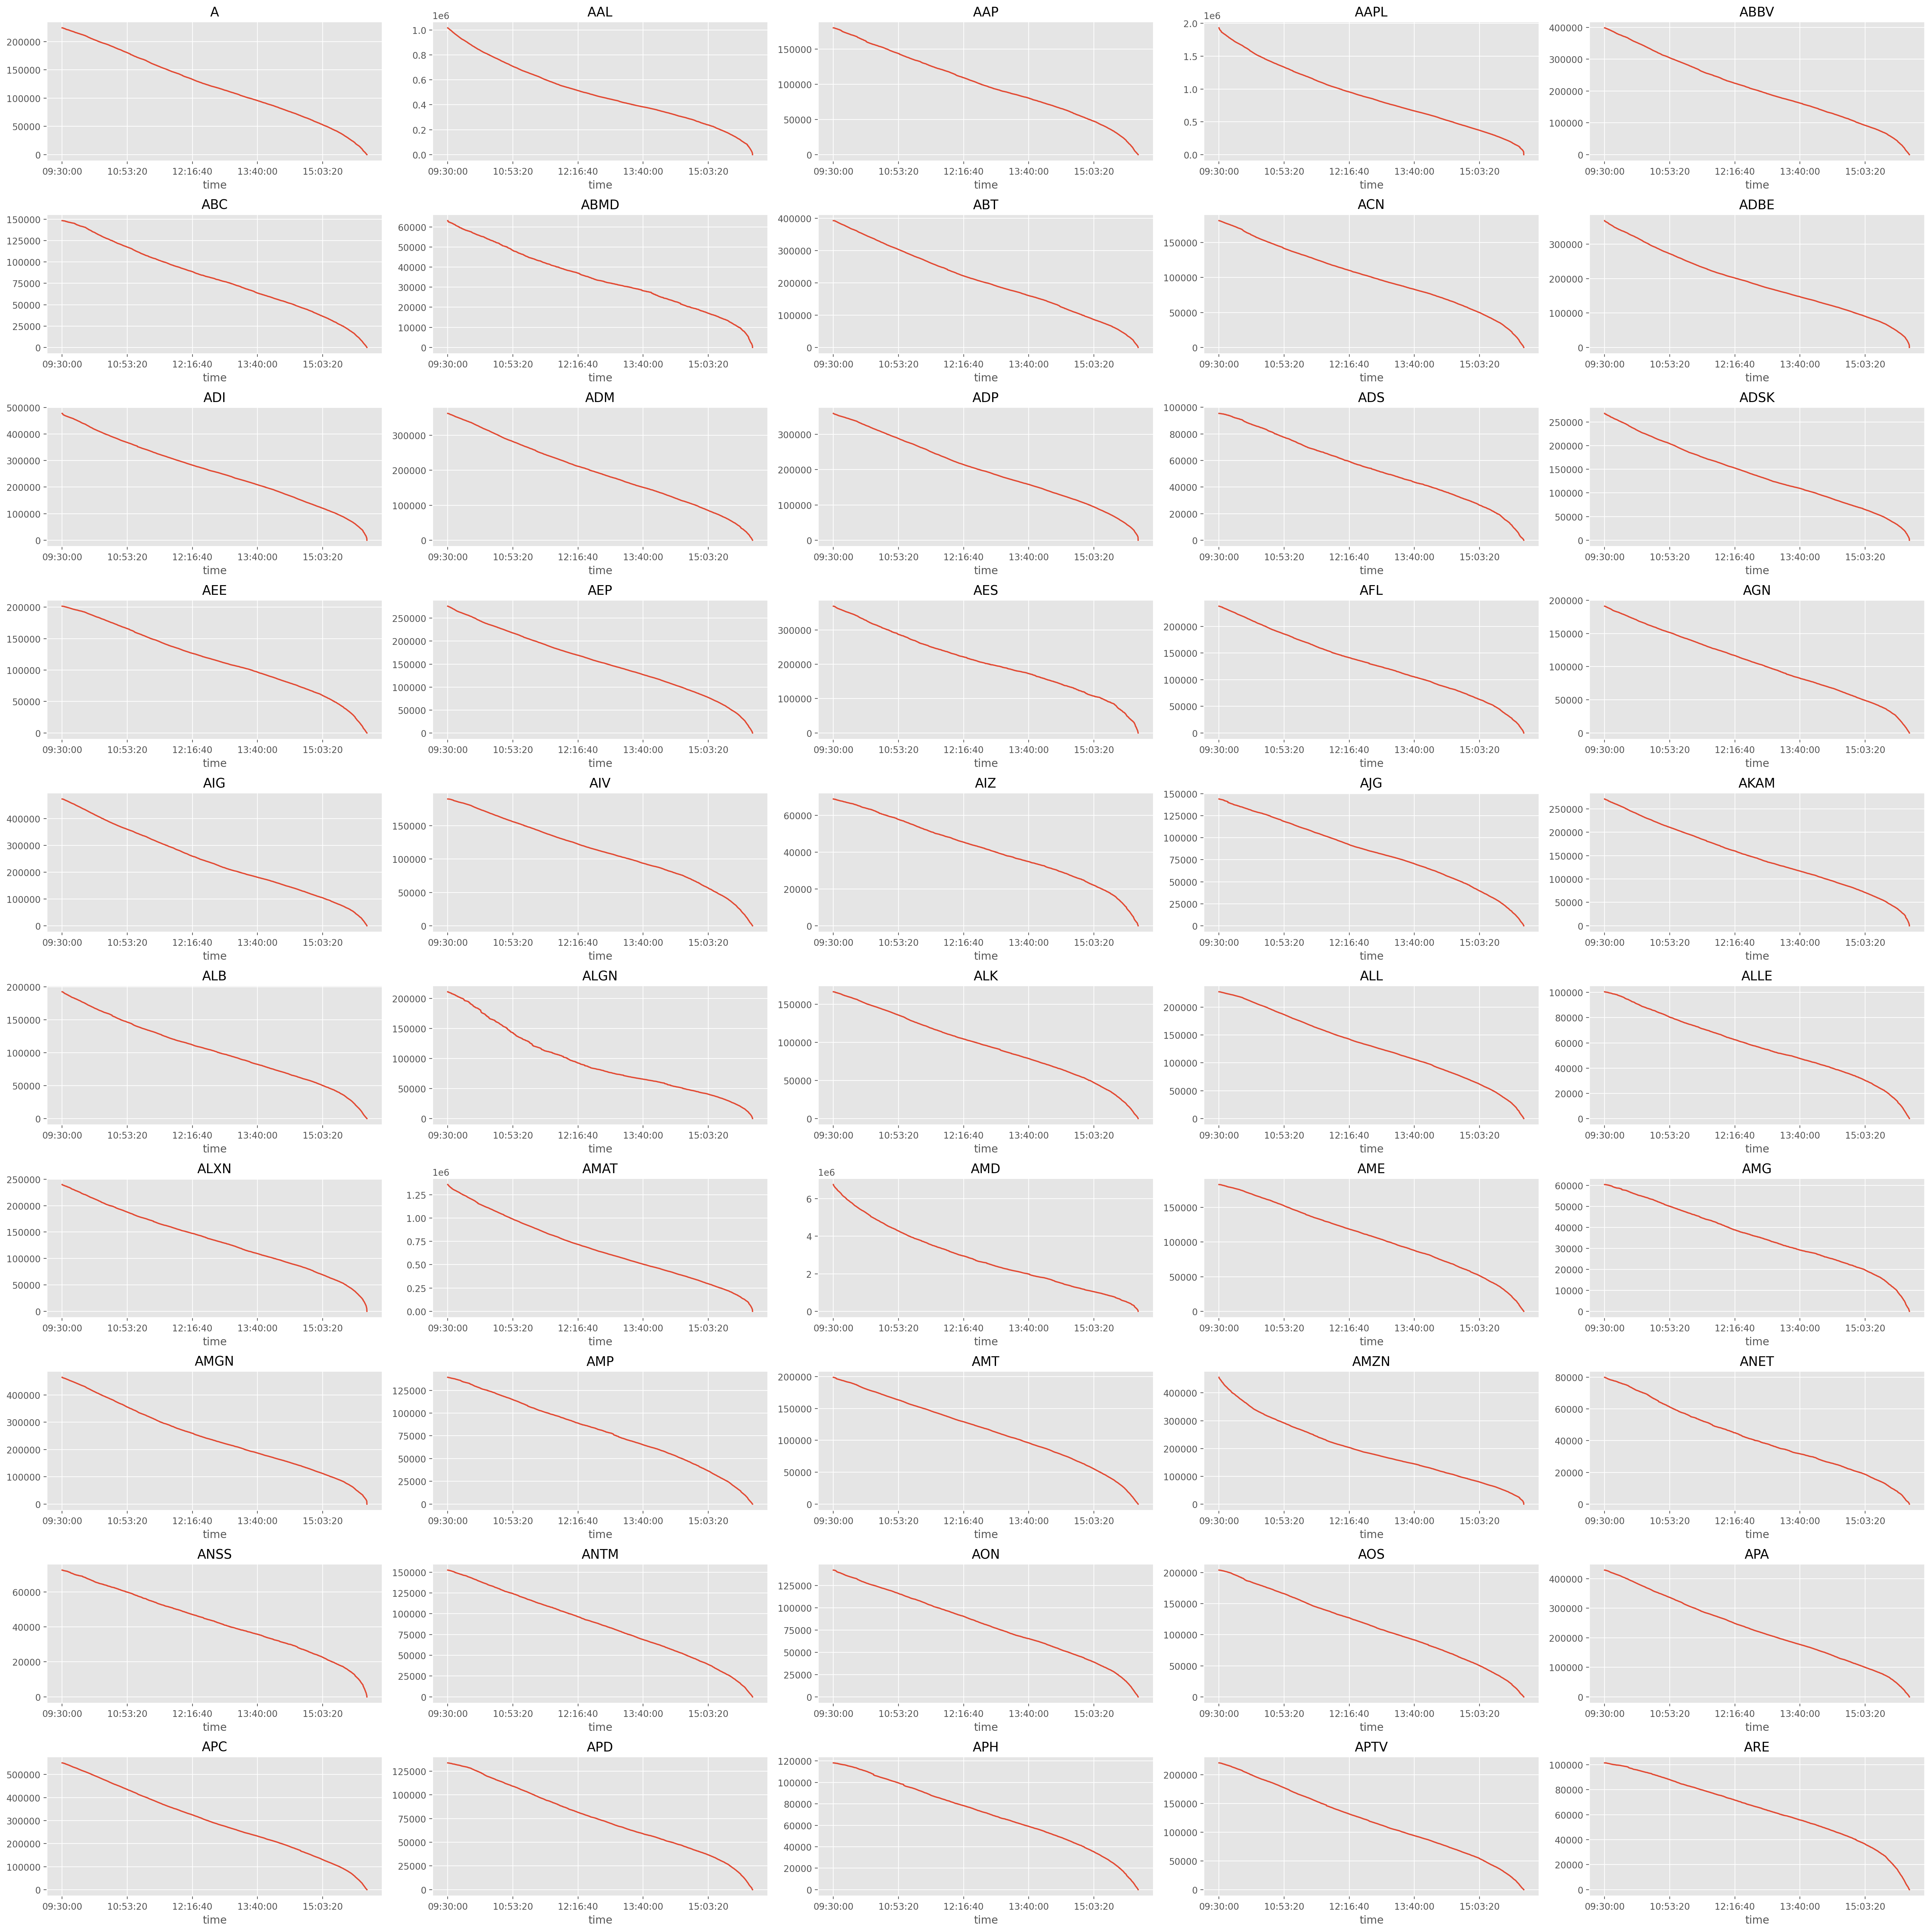

In [7]:
# plot each stock's volume curve
fig, ax = plt.subplots(10, 5, figsize=(30, 30))
for i in range(50):
    stock = vol_curve_df.index[i]
    a, b = i // 5, i % 5
    vol_curve_df.iloc[i].plot(ax=ax[a,b], title=stock)
fig.tight_layout()
fig.savefig(f"EX1_volume_curve.png", dpi=100)

## 2. Synthetic Alpha (WRONG!! DON'T USE THIS!)

Define **forward return** $r$ and **synthetic alpha** $\alpha$:
$$
r_t^h = \frac{P_{t+h} - P_t}{P_t}
$$

$$
\alpha_t^h = x \cdot (P_{t+h} - P_t) + y \cdot (W_{t+h} - W_t) = x r_t^h + \frac{y \cdot (W_{t+h} - W_t)}{P_t}
$$

### 2.1 Vaiance, Correlation
$$
\alpha_t^h = x r_t^h + \frac{y(W_{t+h} - W_t)}{P_t}
$$

$$
\text{Var}(\alpha_t^h) = x^2\text{Var}(r_t^h) + y^2E\left[\frac{1}{P_t^2}\right]h
$$

$$
\text{Cov}(\alpha_t^h, r_t^h) = x\text{Var}(r_t^h)
$$

$$
\text{Corr}(\alpha_t^h, r_t^h) = \frac{\text{Cov}(\alpha_t^h, r_t^h)}{\sqrt{\text{Var}(\alpha_t^h)\text{Var}(r_t^h)}} = \frac{x\sqrt{\text{Var}(r_t^h)}}{\sqrt{(x^2\text{Var}(r_t^h) + y^2E\left[\frac{1}{P_t^2}\right]h)}}
$$

### 2.2
We want:

$$
\frac{x\sqrt{\text{Var}(r_t^h)}}{\sqrt{(x^2\text{Var}(r_t^h) + y^2E\left[ \frac{1}{P_t^2} \right]h)}} = \rho
$$

$$
E[r_t^h|\alpha_t^h] = \alpha^h_t
$$

Computations: (???)

$$
E\left[r_t^h|\alpha_t^h\right] = \rho \alpha_t^h \sqrt{\frac{\text{Var}(r_t^h)}{x^2\text{Var}(r_t^h) + y^2E\left[\frac{1}{P_t^2}\right]h}}
$$

Solutions:

$$
x = \rho ^2 \\
y = \rho \sqrt{1 - \rho^2}\sqrt{\frac{\text{Var}(r^h_t)} {\mathbb{E}\left[\frac{1}{P_t^2}\right]h}}

$$



### 2.3 Calculate synthetic alpha

`ffill`: forward fill \
`bfill`: backward fill

In [14]:
price_df = bin_sample_df[["stock", "date", "midEnd", "time"]].\
                pivot(index=["stock", "date"], columns="time", values="midEnd").\
                fillna(method="ffill", axis="columns").\
                fillna(method="bfill", axis="columns")
return_df = price_df.pct_change(1, axis='columns')

/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_58846/3144556363.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fillna(method="ffill", axis="columns").\
/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_58846/3144556363.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fillna(method="bfill", axis="columns")


We want $\rho = 0.05$
To do the calculation above we need $\text{Var}(r^h_t)$ and $\mathbb{E}[\frac{1}{P^2_t}]$

PROBELMATIC!!

In [15]:
mean_price_minus2 = (price_df ** -2).groupby("stock").mean()
var_return = return_df.groupby("stock").std() ** 2
# mean_price_minus2.head()
# var_return.head()

In [16]:
# get rid of nan column due to return calcs
var_return = var_return.iloc[:, 1:]
mean_price_minus2 = mean_price_minus2.iloc[:, 1:]

In [28]:
rho = 0.1
x = rho ** 2
y_stock = rho * np.sqrt((1 - rho**2)) * np.sqrt(var_return / (mean_price_minus2) * 1)


In [29]:
stock_list = set(return_df.reset_index()["stock"])
dates = price_df.iloc[:,0]["AAPL"].index

corr_df = pd.DataFrame(index=list(stock_list),\
                       columns=dates, \
                       data=np.zeros((len(stock_list),len(dates))))
for stock in stock_list:
    y = y_stock.loc[stock]
    price = price_df.loc[stock].iloc[:, :-1].values
    ret = return_df.loc[stock].iloc[:, 1:].values
    
    # assert price.shape == ret.shape
    shape = price.shape
    W = np.random.normal(0, 1, size=shape)
    
    alpha = x * ret + y.values * W / price
    for i in range(len(dates)):
        corr_df.loc[stock].iloc[i] = np.corrcoef(alpha[i, :], ret[i, :])[0,1]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.041097875023608864

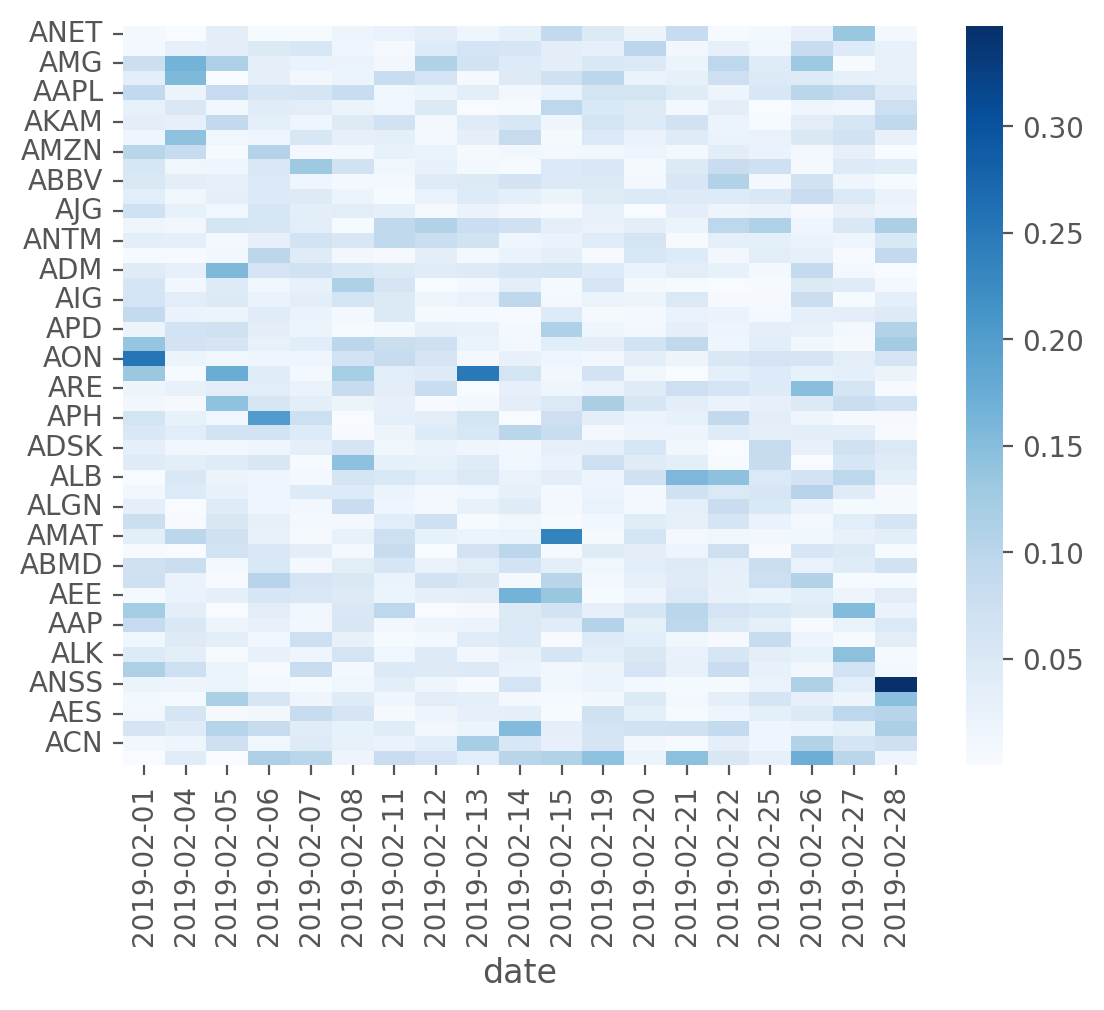

In [30]:
sns.heatmap(np.abs(corr_df - rho) , cmap="Blues")
np.abs(corr_df - rho).mean().mean()

## 3. VWAP

In [75]:
assert (vol_curve_df == vol_curve_df.sort_index()).all().all()
assert (unsigned_traded_volume_df == unsigned_traded_volume_df.sort_index()).all().all()

In [76]:
Q = 1000
v = unsigned_traded_volume_df.set_index(["stock", "date"])
V = vol_curve_df
latency = 1

# v = v.loc["AAPL"].values
# V = V.loc["AAPL"].values
# VWAP3_stockwise(v, W ,1)

In [77]:
def VWAP1(v:np.ndarray, Q:float) -> np.ndarray:
    return (v.T * 1 / v.sum(axis=1)).T * Q

def VWAP2(v:np.ndarray, Q:float) -> np.ndarray:
    shape = v.shape
    latency = 1
    v = np.hstack([np.zeros((v.shape[0], latency)), v[:, :-latency]])
    assert v.shape == shape
    return (v.T * 1 / v.sum(axis=1)).T * Q

def VWAP3_stockwise(v:np.ndarray, V:np.array, Q:float) -> np.ndarray:
    """
    v: unsigned traded volume for one stock
    V: volume curve for one stock
    Q: total volume to trade
    """
    shape = v.shape
    v = np.hstack([np.zeros((v.shape[0], latency)), v[:, :-latency]])
    qq = np.minimum((v / V), 1)
    q = np.zeros_like(qq)
    for j in range(qq.shape[1]):
        q[:, j] = qq[:, j] * Q
        Q = Q - q[:, j]
    return q


In [78]:
Q = 1000
v = unsigned_traded_volume_df.set_index(["stock", "date"])
V = vol_curve_df
latency = 1

q = pd.DataFrame(index=unsigned_traded_volume_df.set_index(["stock", "date"]).index, \
             data=0, columns=unsigned_traded_volume_df.set_index(["stock", "date"]).columns)
q1 = q.copy()
q1.iloc[:,:] = VWAP1(v.values, Q)

q2 = q.copy()
q2.iloc[:,:] = VWAP2(v.values, Q)

In [79]:
stock = "AAPL"
v = unsigned_traded_volume_df.set_index(["stock", "date"]).loc[stock].values
V = vol_curve_df.loc[stock].values
Q = 10000
latency = 1

q3 = q.copy().loc[stock]
q3.iloc[:,:] = VWAP3_stockwise(v, V, Q)

/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_57395/3364995001.py:19: RuntimeWarning: divide by zero encountered in divide
  qq = np.minimum((v / V), 1)


array([1932073.2631579 , 1926759.05263158, 1922580.78947368, ...,
         45929.31578947,   42436.31578947,       0.        ])